
# Install and import packages


In [ ]:
import glob
import json
import torch
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.io import imread
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch.utils.data.sampler import WeightedRandomSampler

%matplotlib inline

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import transforms
import os

In [ ]:
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from torchvision.datasets import DatasetFolder
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
from torchvision.datasets import DatasetFolder
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
!pip install numba
from numba import cuda


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install gradcam dependencies
! pip install grad-cam
import pytorch_grad_cam
from pytorch_grad_cam import GradCAM,FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set random seed

In [ ]:
import random

def set_seed(seed=None, seed_torch=True):


  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')



# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# Encourage run repeatability #tal mod 7/21/24
SEED = 2021
set_seed(seed=SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU.
#np.random.seed(SEED) # done in seed_worker()
#random.seed(SEED)
torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark     = False
torch.use_deterministic_algorithms(False)

Random seed 2021 has been set.


# Data loading and processing

In [ ]:
PATH = 'drive/MyDrive/ADNI/072524_slices/'

def calculate_mean_std(dataset_path):
    all_samples = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.npy'):
                sample = np.load(os.path.join(root, file))
                all_samples.append(sample)

    all_samples = np.stack(all_samples)
    mean = np.mean(all_samples)
    std = np.std(all_samples)
    return mean, std

mean, std = calculate_mean_std(PATH)
print(f"Dataset mean: {mean}, Dataset std: {std}")

Dataset mean: 49.31013107299805, Dataset std: 51.69702911376953


In [ ]:
def npy_loader(file_path):
    sample = np.load(file_path)
    sample = torch.from_numpy(sample).float()
    return sample

# Load the original dataset
original_dataset = DatasetFolder(
    root=PATH,
    loader=npy_loader,
    extensions=['.npy']
)
# Prepare data loaders
ys = np.array([y for _, y in original_dataset])
counts = np.bincount(ys)
label_weights = 1.0 / counts
weights = label_weights[ys]

print("Number of images per class in dataset:")
for c, n, w in zip(original_dataset.classes, counts, label_weights):
    print(f"\t{c}:\tn={n}\tweight={w}")

sampler = WeightedRandomSampler(weights, len(weights), replacement=False)

Number of images per class in dataset:
	AD:	n=184	weight=0.005434782608695652
	Control:	n=244	weight=0.004098360655737705


In [ ]:
# Define normalization transform
normalize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load the original dataset
original_dataset = DatasetFolder(
    root=PATH,
    loader=npy_loader,
    extensions=['.npy']
)

# Extract file paths and labels from the dataset
file_paths, labels = zip(*original_dataset.samples)

# Convert to numpy arrays for easier manipulation
file_paths = np.array(file_paths)
labels = np.array(labels)

# Shuffle and split indices
indices = np.arange(len(file_paths))
np.random.shuffle(indices)

# Calculate split sizes
num_images = len(indices)
num_training = int(0.7 * num_images)
num_validation = int(0.15 * num_images)
num_test = num_images - (num_training + num_validation)

# Split indices into train, validation, and test sets
train_indices, temp_indices = indices[:num_training], indices[num_training:]
validation_indices, test_indices = train_test_split(temp_indices, test_size=num_test, random_state=23)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, indices, transform=None):
        self.file_paths = file_paths[indices]
        self.labels = labels[indices]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]
        sample = np.load(path)  # Load numpy array from path
        sample = torch.tensor(sample, dtype=torch.float32) / 255
        sample = sample.unsqueeze(0)  # Add channel dimension for grayscale images

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# Create datasets
train_dataset = CustomDataset(file_paths, labels, train_indices, transform=normalize_transform)
validation_dataset = CustomDataset(file_paths, labels, validation_indices, transform=normalize_transform)
test_dataset = CustomDataset(file_paths, labels, test_indices, transform=normalize_transform)

# Sampler and data loader for training dataset
ys = np.array([y for _, y in train_dataset])
counts = np.bincount(ys)
label_weights = 1.0 / counts
weights = label_weights[ys]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

# Other data augmentations and normalization
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.5))], p=.25),
    transforms.RandomRotation(degrees=5),  # Rotation, -5 to 5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Translation, -5 pixels to 5 pixels
    transforms.RandomAffine(degrees=0, scale=(0.95, 1.05)),  # Scale 95% to 105%
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply transformations to only the training dataset
augmented_train_dataset = CustomDataset(file_paths, labels, train_indices, transform=data_transforms)

# Concat to original training dataset
train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example to check dataset sizes
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of validation dataset: {len(validation_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")


Size of training dataset: 598
Size of validation dataset: 64
Size of test dataset: 65


In [ ]:
# Get a sample from the augmented dataset (for example, the first sample)
sample, target = validation_dataset[1]
sample = sample.squeeze(0)

# Print the shape of the sample
print(sample.shape)

torch.Size([192, 192])


In [ ]:
len(train_dataset)

In [ ]:
# show batch of images
def show_batch(x, y):
  plt.imshow(x, cmap = 'gray')
  plt.axis('off')  # Hide axes
  plt.show()

# show a random batch from the data loader
# (run this cell repeatedly to see different batches)
for x, y in test_dataloader:
  print(x.shape)
  x = x[0, :, :]
  show_batch(x, y)
  print(x.shape)
  break

# Construct model

In [ ]:
class Vgg2D(torch.nn.Module):

  def __init__(
          self,
          input_size,
          fmaps=8,
          downsample_factors=[(2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2)],
          output_classes=2):

    super(Vgg2D, self).__init__()

    self.input_size = input_size

    current_fmaps = 1
    current_size = tuple(input_size)
    dropout_prob = 0.25

    features = []
    for i in range(len(downsample_factors)):

      features += [
          torch.nn.Conv2d(
              current_fmaps,
              fmaps,
              kernel_size=3,
              padding=1),
          torch.nn.BatchNorm2d(fmaps),
          torch.nn.ReLU(inplace=True),
          # torch.nn.Dropout(p=dropout_prob),

          # torch.nn.Conv2d(
          #     fmaps,
          #     fmaps,
          #     kernel_size=3,
          #     padding=1),
          # torch.nn.BatchNorm2d(fmaps),
          # torch.nn.ReLU(inplace=True),
          # # torch.nn.Dropout(p=dropout_prob),

          torch.nn.Conv2d(
              fmaps,
              fmaps,
              kernel_size=3,
              padding=1),
          torch.nn.BatchNorm2d(fmaps),
          torch.nn.ReLU(inplace=True),
          # torch.nn.Dropout(p=dropout_prob),
          torch.nn.MaxPool2d(downsample_factors[i])
      ]

      current_fmaps = fmaps
      fmaps *= 2

      size = tuple(
          int(c/d)
          for c, d in zip(current_size, downsample_factors[i]))
      check = (
          s*d == c
          for s, d, c in zip(size, downsample_factors[i], current_size))
      assert all(check), \
          "Can not downsample %s by chosen downsample factor" % \
          (current_size,)
      current_size = size

    self.features = torch.nn.Sequential(*features)

    classifier = [
        torch.nn.Linear(
            current_size[0] *
            current_size[1] *
            current_fmaps,
            256),
        torch.nn.ReLU(inplace=True),
        # torch.nn.Dropout(p=dropout_prob),
        torch.nn.Linear(
            256,
            32),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=.25),
        torch.nn.Linear(
            32,
            output_classes)
    ]

    self.classifier = torch.nn.Sequential(*classifier)

  def forward(self, raw):

    # add a channel dimension to raw
    shape = tuple(raw.shape)
    raw = raw.reshape(shape[0], shape[1], shape[2], shape[3])

    # compute features
    f = self.features(raw)
    f = f.view(f.size(0), -1)

    # classify
    y = self.classifier(f)

    return y

In [ ]:
# get the size of our images
for x, y in train_dataset:
  x = x.squeeze(0)
  print(x.shape)
  input_size = x.shape
  break

# create the model to train
model = Vgg2D(input_size)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

# create a loss
loss = torch.nn.CrossEntropyLoss()

# create an optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

torch.Size([192, 192])
Total number of parameters: 1780538


In [ ]:
# Train model
# use a GPU, if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Will use device {device} for training")

Will use device cpu for training


In [ ]:
# Define the L1 Regularization Term
def l1_regularization(model, lambda_l1):
    l1_penalty = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_penalty = l1_penalty + torch.sum(torch.abs(param))
    return lambda_l1 * l1_penalty

In [ ]:
def train(dataloader, optimizer, loss, device, lambda_l1=0.006):
  '''Train the model for one epoch.'''

  # set the model into train mode
  model.train()

  epoch_loss, num_batches = 0, 0
  for x, y in tqdm(train_dataloader, 'train'):

    running_loss = 0.0

    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()

    y_pred = model(x)
    l = loss(y_pred, y)

    # Add L1 regularization
    l1_penalty = l1_regularization(model, lambda_l1)
    l = l + l1_penalty
    l.backward()

    optimizer.step()

    epoch_loss += l.detach()
    num_batches += 1

  return epoch_loss/num_batches


def evaluate(dataloader, name, device):

  correct = 0
  total = 0
  for x, y in tqdm(dataloader, name):

    x, y = x.to(device), y.to(device)

    logits = model(x)
    probs = torch.nn.Softmax(dim=1)(logits)
    predictions = torch.argmax(probs, dim=1)

    correct += int(torch.sum(predictions == y).cpu().detach().numpy())
    total += len(y)

  accuracy = correct/total

  return accuracy


def validate(validation_dataloader, device):
  '''Evaluate prediction accuracy on the validation dataset.'''

  model.eval()

  return evaluate(validation_dataloader, 'validate', device)


def test(test_dataloader, device):
  '''Evaluate prediction accuracy on the test dataset.'''

  model.eval()

  return evaluate(test_dataloader, 'test', device)

In [ ]:
# Function to calculate AUC and F1 score
def evaluate_metrics(model, data_loader, device):
    model.eval()
    all_targets = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification, take prob of class 1

            all_targets.extend(targets.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert probabilities to binary predictions
    all_preds = np.where(np.array(all_probs) > 0.5, 1, 0)

    return roc_auc_score(all_targets, all_probs), f1_score(all_targets, all_preds, average='weighted')

In [ ]:
def train_model(dataloader, validation_dataset,
                       optimizer, loss,
                       num_epochs=10, device=device):

  training_losses = []
  accuracy_list= []

  for epoch in range(num_epochs):
    epoch_loss = train(dataloader, optimizer, loss, device=device)
    print(f"epoch {epoch}, training loss={epoch_loss}")
    training_losses.append(epoch_loss)
    gc.collect()

    # Convert training losses to CPU and then to numpy
    training_losses_cpu = [loss.cpu().item() for loss in training_losses]
    print(training_losses_cpu)

    accuracy = validate(validation_dataset, device=device)
    print(f"epoch {epoch}, validation accuracy={accuracy}")
    accuracy_list.append(accuracy)
    print(accuracy_list)

  # Plotting the training loss
  plt.plot(range(1, num_epochs + 1), training_losses_cpu, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.grid(False)
  plt.show()

  # Plot accuracy
  plt.plot(range(1, num_epochs + 1), accuracy_list, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Validation Accuracy')
  plt.title('Validation Accuracy over Epochs')
  plt.grid(False)
  plt.show()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

3519

# Train model and assess performance

train: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


epoch 0, training loss=73.60759735107422
[73.60759735107422]


validate: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


epoch 0, validation accuracy=0.65625
[0.65625]


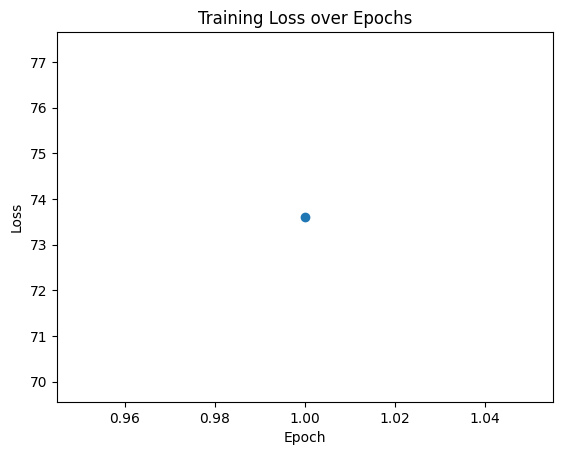

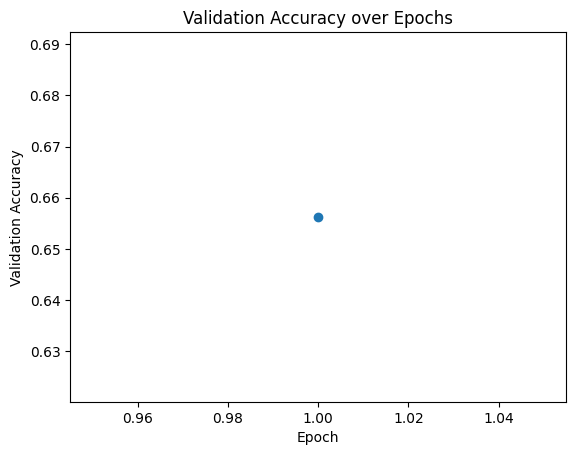

In [ ]:
train_model(train_dataloader, validation_dataloader,
                     optimizer, loss,
                     num_epochs=20, device=device)

In [ ]:
accuracy = test(test_dataloader, device=device)
print(f"final test accuracy: {accuracy}")

test: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

final test accuracy: 0.7692307692307693


In [ ]:
# Calculate AUC
auc, f1 = evaluate_metrics(model, test_dataloader, device)
print(f"AUC: {auc:.4f}")
print(f"F1: {f1:.4f}")

AUC: 0.8801
F1: 0.7486


In [ ]:
# Most recent good run
# model_checkpoint_072424_1.2.pth

In [ ]:
# Assuming `model` is your model and `optimizer` is your optimizer
def save_checkpoint(model, optimizer, epoch, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)

# Example usage:
save_checkpoint(model, optimizer, 25, 'drive/MyDrive/ADNI/072524_best.pth')

In [ ]:
# Load checkpoint
def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

model, optimizer, start_epoch = load_checkpoint(model, optimizer, 'drive/MyDrive/ADNI/072524_best.pth')

# Examine feature importance with GradCAM

In [ ]:
input_tensor,label = next(iter(test_dataloader))
input_tensor,label = torch.tensor(input_tensor), torch.tensor(label)
input_tensor.to(device), label.to(device)
input_tensor = input_tensor / 255.0
input_tensor = input_tensor.to(torch.float32)
# input_tensor = input_tensor.permute(1, 0, 2,3)
input_tensor.shape

<ipython-input-63-a312a11509d5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor,label = torch.tensor(input_tensor), torch.tensor(label)


torch.Size([16, 1, 192, 192])

In [ ]:
# for i in iter(test_dataloader):
#   print(i)

In [ ]:
print(model)

Vgg2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, e

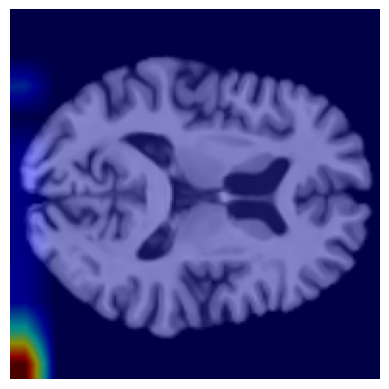

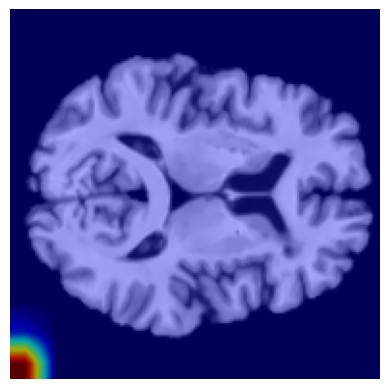

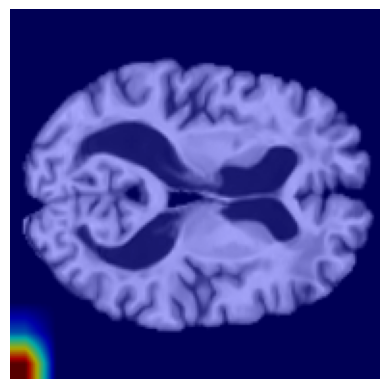

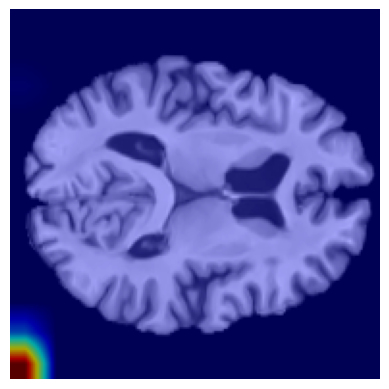

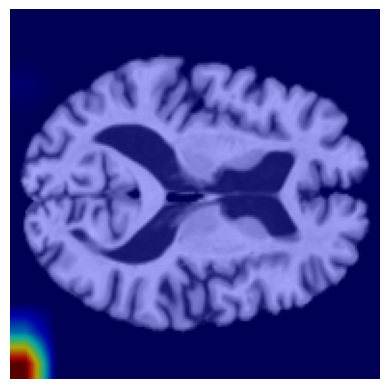

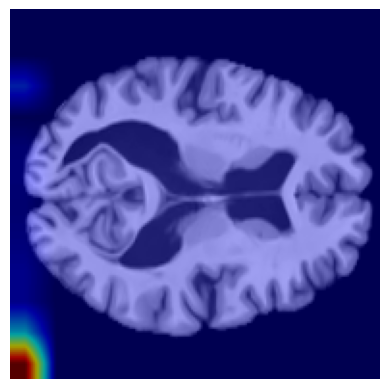

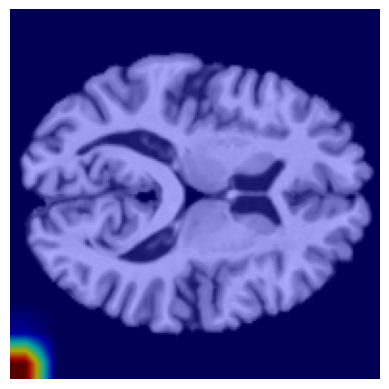

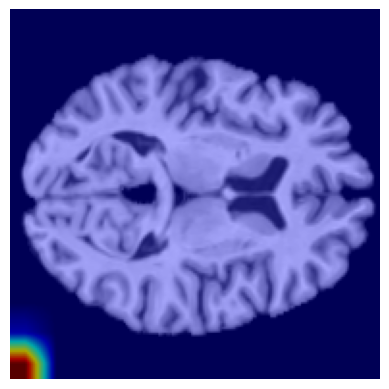

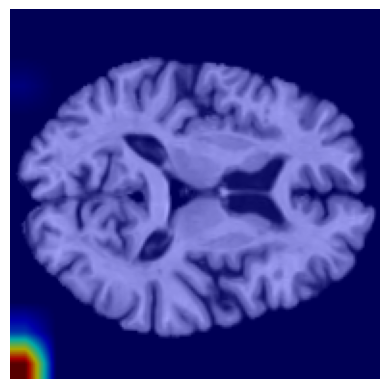

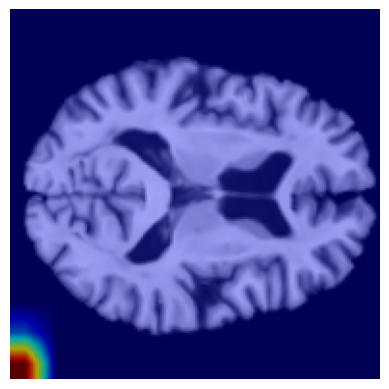

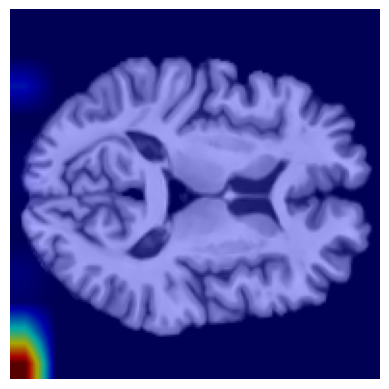

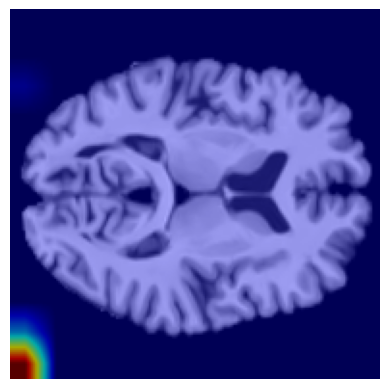

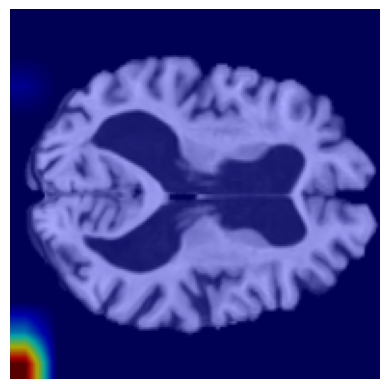

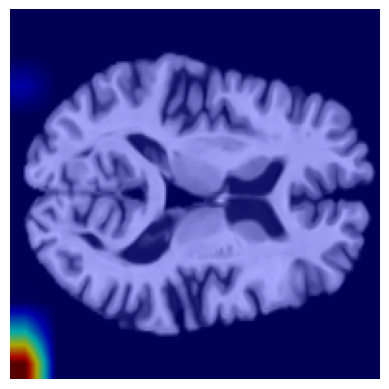

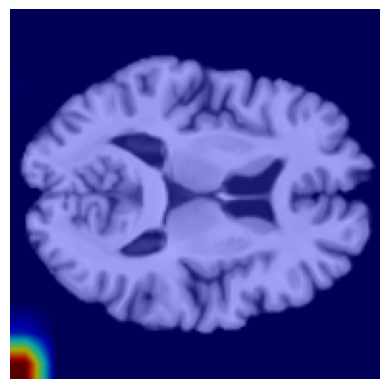

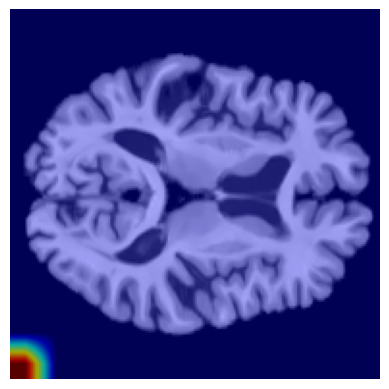

In [81]:
def visualize_gradcam(model, input_tensor, target_class, target_layer, aug_smooth=False, eigen_smooth=False):

    # Define the GradCAM object
    # cam = FullGrad(model=model, target_layers=[target_layer])

    cam = GradCAM(model=model, target_layers=[target_layer])

    # Define target
    targets = [ClassifierOutputTarget(target_class)]

    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets* input_tensor.size(0), aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)

    # Loop through batch and show Grad-CAM
    for i in range(grayscale_cam.shape[0]):
        grayscale_cam_i = grayscale_cam[i, :]
        input_image_i = input_tensor[i].numpy().transpose(1, 2, 0)  # Convert to HWC format
        input_image_i = np.repeat(input_image_i, 3, axis=2)  # Repeat grayscale image across 3 channels
        # print(input_image_i.shape)
        # print(grayscale_cam_i.shape)

        # Ensure the image is in the correct range [0, 1]
        input_image_i = (input_image_i - input_image_i.min()) / (input_image_i.max() - input_image_i.min())

        visualization = show_cam_on_image(input_image_i, grayscale_cam_i, use_rgb=True)

        # Visualize
        # plt.figure()
        # plt.title(y)
        plt.imshow(visualization)
        plt.axis('off')
        plt.show()

# Example usage
# Assuming you have a model and input_tensor (batch of images) ready
model = model
input_tensor = input_tensor  # Example input tensor
target_class = original_dataset.classes.index('AD')
target_layer = model.features[33]  # Experiment with different layers

visualize_gradcam(model, input_tensor, target_class, target_layer, aug_smooth=False, eigen_smooth=False)